<a href="https://www.kaggle.com/code/tammysilva/phys243-hw4-jiaxin-tang-dt-on-mnist-dataset?scriptVersionId=92857789" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-submission/sample_submission.csv
/kaggle/input/sample-submission/train.csv
/kaggle/input/sample-submission/test.csv


# 0 Summary
### In this project, I use a decision tree algorithm on the MNIST dataset to find all of the 9s and compare the performance with a random forest algorithm. The steps are as follows.
1. Load packages and Load Data
2. Exploratory Data Analysis
3. Feature Preprocessing and Scaling
4. Model Training with Decision Tree Algorithm and Random Forest Algorithm
* 4.1 Cross Validation when training to find the 9s
* 4.2 Use Grid Search to Find Optimal Hyperparameters
5. Model Evaluation with Confusion Matrix
6. Feature Importance Discussion

# 1 Load Packages and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics

In [3]:
df = pd.read_csv("../input/sample-submission/sample_submission.csv")
test_df = pd.read_csv("../input/sample-submission/test.csv")
train_df = pd.read_csv("../input/sample-submission/train.csv")

# 2 Exploratory Data Analysis

In [4]:
df.head(3)

,ImageId,Label
0,1,0
1,2,0
2,3,0


In [5]:
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print("Shape of training data: ", train_df.shape)

Shape of training data:  (42000, 785)


In [7]:
test_df.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print("Shape of testing data: ", test_df.shape)

Shape of testing data:  (28000, 784)


In [9]:
# Null value
print('Number of null values in training set:',train_df.isnull().sum().sum())
print('Number of null values in test set:',test_df.isnull().sum().sum())

Number of null values in training set: 0
Number of null values in test set: 0


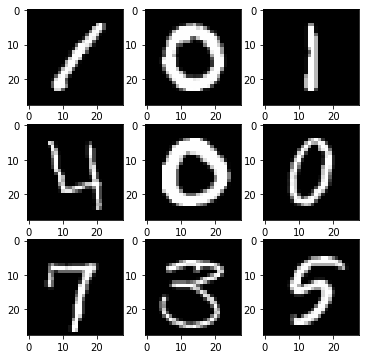

In [10]:
# Preview first few images
# Figure size
plt.figure(figsize=(6,6))

# Subplot 
for i in range(9):
    img = np.asarray(train_df.iloc[i,1:].values.reshape((28,28))/255);
    ax=plt.subplot(3, 3, i+1)
    ax.grid(False)
    plt.imshow(img, cmap='gray')
    
plt.show()

Text(0.5, 1.0, 'Distribution of labels in training set')

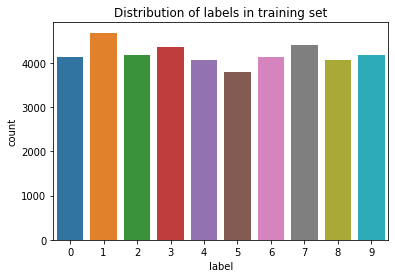

In [11]:
# Explore label distribution
sns.countplot(x='label', data=train_df)
plt.title('Distribution of labels in training set')

# 3 Feature Preprocessing and Spliting

In [12]:
# Labels
y=train_df.label

# Features scaled to lie in [0,1]
X=train_df.drop('label', axis=1)/255

# Splite data into training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 33600 observation with 784 features
test data has 8400 observation with 784 features


In [13]:
X_train.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
36102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y_train.head(9)

36102    2
3097     9
1296     9
33452    2
33491    3
35593    1
5939     6
35424    3
39267    4
Name: label, dtype: int64

In [15]:
# Set a Target Binary Classifier to Find the 9s
# true if 9 otherwise false
y_train_9 = (y_train == 9)
y_train_9

36102    False
3097      True
1296      True
33452    False
33491    False
         ...  
28738    False
38012    False
37899    False
3235     False
3583     False
Name: label, Length: 33600, dtype: bool

# 4 Model Training

In [16]:
# Decision Tree
classifier_DT = DecisionTreeClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [17]:
# Use Decision Tree to train the model
classifier_DT.fit(X_train,y_train)

# Prediction of test data
y_pred_DT = classifier_DT.predict(X_test)

# Accuracy of the test data
classifier_DT.score(X_test, y_test)

0.8527380952380952

In [18]:
# Use Decision Tree to train the model
classifier_RF.fit(X_train,y_train)

# Prediction of test data
y_pred_RF = classifier_RF.predict(X_test)

# Accuracy of the test data
classifier_RF.score(X_test, y_test)

0.9625

## 4.1 Cross Validation when training to find the 9s

In [19]:
# Use 5-fold Cross Validation to get the accuracy for the two models
model_names = ['Decision Tree','Random Forest']
model_list = [classifier_DT, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train_9, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.95877976 0.9516369  0.96041667 0.95892857 0.95833333]
Model accuracy of Decision Tree is 0.9576190476190476
[0.98095238 0.97842262 0.9796131  0.9827381  0.98244048]
Model accuracy of Random Forest is 0.9808333333333333


## 4.2 Find Optimal Hyperparameters

### 4.2.1 Find Optimal Hyperparameters: Decision Tree

In [20]:
# Find the depth by the highest accuracy
# List of values to try for max_depth:
max_depth_range = list(range(1, 30))
# List to store the accuracy for each value of max_depth:
accuracy = []

for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_pred_DT)
    accuracy.append(score)

max_accuracy = max(accuracy)
max_dep = accuracy.index(max_accuracy)
print("The depth with highest accuracy is", max_dep)

The depth with highest accuracy is 27


In [21]:
best_DT_model = DecisionTreeClassifier(max_depth = max_dep)

### 4.3.2 Find Optimal Hyperparameters: Random Forest

In [22]:
#Loss/cost function --> (wx + b - y) ^2 + ƛ * |w| --> ƛ is a hyperparameter

from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [23]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [60, 80, 100]})

In [24]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.9437202380952382
Best parameters set:
max_depth:10
n_estimators:100


In [25]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [26]:
best_RF_model

RandomForestClassifier(max_depth=10)

# 5 Model evaluation

In [27]:
y_pred_9_DT = cross_val_predict(best_DT_model, X_train, y_train_9, cv=3)
y_pred_9_RF = cross_val_predict(best_RF_model, X_train, y_train_9, cv=3)


## Confusion Matrix (Precision, Recall, Accuracy)

In [28]:
confusion_matrix(y_train_9, y_pred_9_DT)

array([[29551,   699],
       [  710,  2640]])

In [29]:
confusion_matrix(y_train_9, y_pred_9_RF)

array([[30178,    72],
       [  792,  2558]])

In [30]:
# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ()

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

In [31]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Decision Tree", confusion_matrix(y_train_9, y_pred_9_DT)),
    ("Random Forest", confusion_matrix(y_train_9, y_pred_9_RF))
]

draw_confusion_matrices(confusion_matrices)

Decision Tree
Accuracy is: 0.9580654761904762
precision is: 0.7906558849955077
recall is: 0.7880597014925373

Random Forest
Accuracy is: 0.9742857142857143
precision is: 0.9726235741444867
recall is: 0.7635820895522388



# 6 Feature importance

In [32]:
# Random Forest
X_RF = X_train.copy()
X_RF.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
36102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


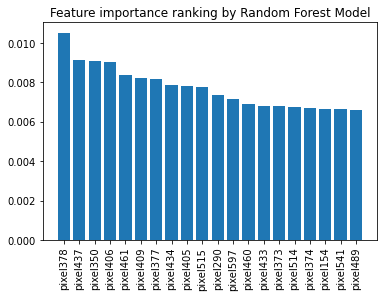

In [33]:
# check feature importance of random forest for feature selection
importances = best_RF_model.feature_importances_
feature_name = X_RF.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.title("Feature importance ranking by Random Forest Model")
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()